In [1]:
import torch
import pandas as pd
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, auc 
from sklearn.metrics import roc_auc_score
import numpy as np
import gc
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from scipy.special import softmax
from transformers import AdamW, AutoTokenizer,EsmForSequenceClassification, EsmForTokenClassification
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
import random
import torch.nn.functional as F
import numpy as np
import io
from sklearn.decomposition import PCA
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.patches as mpatches

### Load protein sequencs

In [88]:
#### load +Droplet drivers and +Amyloids ####

with open('final_files/gr_protein_seq_d_404', 'rb') as fp:
                        gr_uniprot_seq_d= pickle.load(fp)
        
with open('final_files/gr_protein_seq_a_113', 'rb') as fp:
                        gr_uniprot_seq_a= pickle.load(fp)

In [11]:
#### load stable proteins which are unlikely to undergo phase transition (-PT) ####

with open('final_files/gr_protein_seq_pdb_360', 'rb') as fp:
                        gr_protein_seq_pdb_360 = pickle.load(fp)

In [12]:
### load protein sequences extracted from the AMP-AD database

with open('final_files/protein_seq_AD_alpha', 'rb') as fp:
                        protein_seq_AD_alpha = pickle.load(fp)
        
with open('final_files/AD_esm_uniprots_not_in_alpha_seq', 'rb') as fp:
                        AD_esm_uniprots_not_in_alpha_seq = pickle.load(fp)

AD_seq = protein_seq_AD_alpha + AD_esm_uniprots_not_in_alpha_seq

In [13]:
#### AD seq that were predicted as droplets or amyloids (droplets+amyloid class) by LM+ML

## indexes of AD sequences that were predicted as droplets+amyloids
with open('final_files/alpha_ESM_seq_AD_das_0_indexes', 'rb') as fp:
                        alpha_ESM_seq_AD_das_0_indexes = pickle.load(fp)
        
AD_seq = np.array(AD_seq[0:183] + AD_seq[184:])  ## remove 183
AD_seq = AD_seq[alpha_ESM_seq_AD_das_0_indexes].tolist()

In [14]:
## To run beta & tau - to read amyloid_beta_precursor  and tau protein sequences

with open('final_files/amyloid_beta_precursor', 'rb') as fp:
                        amyloid_beta_precursor = pickle.load(fp)
with open('final_files/tau_seq_758', 'rb') as fp:
                        tau_758= [pickle.load(fp)]

x_input = amyloid_beta_precursor  ## user should choise: amyloid_beta_precursor / tau_758

In [15]:
amyloid_beta_precursor 

['MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLQKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN']

In [83]:
### amyloid beta 42
beta42 = 'DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA'
x_input=[beta42]

In [16]:
def seq_len(sequences, seq_class):
    ### plot sequence lenght for the four classes: droplet +drivers, +amyloids, AMP-AD and -PT
    ## user should choose x - class sequences
    "input: list of sequences and their class"
    "Output: distribution of sequence lengths in each class"
    
    plt.figure(figsize=(5,5))
    len_s= [len(i) for i in sequences]
    plt.hist(len_s, alpha=0.5)
    plt.xlabel('Length (a.a)', fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
  
    print(f'length distribution of sequences in class {seq_class}')
    
    return()

length distribution of sequences in class +Amyloids


()

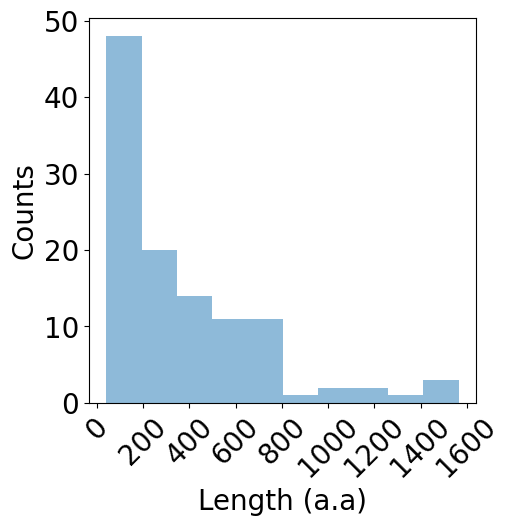

In [17]:
seq_len(gr_uniprot_seq_a, '+Amyloids')

### Define input (sequences) and output (labels) for train/test ESMFold model

In [18]:
def run_data_taskB(gr_uniprot_seq_d,gr_uniprot_seq_a): 
    
    "input: protein sequences of +Droplet drivers and +Amyloids"
    "output: data for task B. x: merged seqeunces of +Droplet drivers and +Amyloids, y: labels"
    
    ### To run Classification task B: get protein sequences and labels
    # amino acid sequences with labels: 0 - +Amyloids    1 - +Droplet drivers

    pos = [1]*len(gr_uniprot_seq_d[:])
    neg = [0]*len(gr_uniprot_seq_a[:])

    # droplets and amyloids dataset
    y = pos + neg
    x = gr_uniprot_seq_d[:] + gr_uniprot_seq_a[:]
    
    print('This is the data for task B')
    print('len y task B is', len(y))
    print('len x task B is', len(x))
    
    return(x,y)

In [91]:
### Run this line to get the data for classification task B AND A.
## This function produce the data for classification task B

x,y=run_data_taskB(gr_uniprot_seq_d,gr_uniprot_seq_a)
x_input=x

This is the data for task B
len y task B is 517
len x task B is 517


In [92]:
### need to use the train / test indexes to distinguish between +Droplet drivers and +Amyloids in classification task A

ycolor = y + [2]*len(gr_protein_seq_pdb_360)
ycolor

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [93]:
def run_data_taskA(x,y):

    ### To run Classification task A:get protein sequences and labels
    # +Droplet drivers & +Amyloids versus stable proteins dataset (-PT)

    ### amino acid sequences with labels:  0 +Droplet drivers & +Amyloids    1 -PT ###

    y_Droplets_Amyloids = [0]*len(y)
    y_PT = [1]*len(gr_protein_seq_pdb_360)

    y_DA_PT = y_Droplets_Amyloids + y_PT 
    x_DA_PT = x + gr_protein_seq_pdb_360

    x = x_DA_PT
    y = y_DA_PT
    
    print('This is the data for task A')
    print('len y is', len(y))
    print('len x is', len(x))
    
    return(x,y)

In [94]:
## This function produce the data for classification task A

x,y=run_data_taskA(x,y)
x_input=x

This is the data for task A
len y is 877
len x is 877


### Mutated seqeunces

In [2]:
def FUS_point_mut():
    "Output: FUS mutated sequences (known point mutations in ALS) or FUS WT"
    
    ### FUS protein wild type and point mutation

    fus_w = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY'
    #fus_m = fus_w[0:155]+'E'+fus_w[156:]

    fus_m_525 = fus_w[0:524]+'L'+fus_w[525:]
    fus_m_521 = fus_w[0:520]+'C'+fus_w[521:]
    fus_m_244 = fus_w[0:243]+'C'+fus_w[244:]

    return([fus_w],[fus_m_525], [fus_m_521], [fus_m_244])

In [51]:
### get FUS wild type (WT) or a point mutation FUS sequence
fus_w, fus_m_525, fus_m_521, fus_m_244 = FUS_point_mut()
x_input = fus_m_244   ## user should put his choice: FUS WT/ P525L/ R521C/ R244C

In [16]:
def FUS_mutated_sequences():
### FUS protein wild type and mutated sequences based on Ref. https://www.nature.com/articles/s41556-020-00578-6
    "Output: mutated seqeunces or the WT"
    
    fus_w = ['MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY']

    fus_idr = fus_w[0][0:214]

    l5 = [i for i in fus_idr]

    ## 5 5Y->S
    l5[16] = 'S'
    l5[74] = 'S'
    l5[80] = 'S'
    l5[142] = 'S'
    l5[148] = 'S'


    l9 = [i for i in fus_idr]
    ## 9Y->S
    l9[13] = 'S'
    l9[32] = 'S'
    l9[37] = 'S'
    l9[40] = 'S'
    l9[129] = 'S'
    l9[135] = 'S'
    l9[142] = 'S'
    l9[148] = 'S'
    l9[154] = 'S'


    l27 = [i for i in fus_idr]
    ## 27Y->S
    l27[5] = 'S'
    l27[13] = 'S'
    l27[16] = 'S'
    l27[24] = 'S'
    l27[32] = 'S'
    l27[37] = 'S'
    l27[40] = 'S'
    l27[49] = 'S'
    l27[54] = 'S'
    l27[57] = 'S'
    l27[65] = 'S'
    l27[74] = 'S'
    l27[80] = 'S'
    l27[90] = 'S'
    l27[96] = 'S'
    l27[99] = 'S'
    l27[112] = 'S'
    l27[121] = 'S'
    l27[129] = 'S'
    l27[135] = 'S'
    l27[142] = 'S'
    l27[148] = 'S'
    l27[154] = 'S'
    l27[160] = 'S'
    l27[176] = 'S'
    l27[193] = 'S'
    l27[207] = 'S'


    x5 = [''.join(l5)]
    x9 = [''.join(l9)]
    x27 = [''.join(l27)]
    return(fus_w, x5, x9, x27)

In [17]:
### get FUS wild type (WT) or mutated FUS sequences
fus_w, fus_m5, fus_m9, fus_m27 = FUS_mutated_sequences()
x_input = fus_m27  ## user should put his choice: FUS WT/ 5Y->S/ 9Y->S/ 27Y->S
x_input

['MASNDSTQQATQSSGASPTQPGQGSSQQSSQPSGQQSSSGSSQSTDTSGSGQSSSSSSGQSQNTGSGTQSTPQGSGSTGGSGSSQSSQSSSGQQSSSPGSGQQPAPSSTSGSSGSSSQSSSSGQPQSGSSSQQPSSGGQQQSSGQQQSSNPPQGSGQQNQSNSSSGGGGGGGGGGNSGQDQSSMSSGGGSGGGSGNQDQSGGGGSGGSGQQDRG']

In [2]:
def hnRNPA1_plcd():
    ## Ref. https://www.nature.com/articles/s41557-021-00840-w.
    "Output: mutated plcd region: 1. replace Y with F. 2. replace F with Y"

    ### hnRNPA1 
    hn = 'MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGFAFVTFDDHDSVDKIVIQKYHTVNGHNCEVRKALSKQEMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGGYGGGGPGYSGGSRGYGSGGQGYGNQGSGYGGSGSYDSYNNGGGGGFGGGSGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGPYGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'

    plcd = 'MASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGGYGGGGPGYSGGSRGYGSGGQGYGNQGSGYGGSGSYDSYNNGGGGGFGGGSGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGPYGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF'
    plcd_Y = plcd.replace('F','Y')
    plcd_F = plcd.replace('Y','F')

    return([hn], [plcd_Y], [plcd_F])   

In [4]:
### get FUS wild type (WT) or mutated FUS sequences
hn, plcd_Y, plcd_F  = hnRNPA1_plcd()
x_input = hn  ## user should put his choice: hnRNPA1/ plcd F->Y/ plcd Y-F
x_input

['MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGFAFVTFDDHDSVDKIVIQKYHTVNGHNCEVRKALSKQEMASASSSQRGRSGSGNFGGGRGGGFGGNDNFGRGGNFSGRGGFGGSRGGGGYGGSGDGYNGFGNDGGYGGGGPGYSGGSRGYGSGGQGYGNQGSGYGGSGSYDSYNNGGGGGFGGGSGSNFGGGGSYNDFGNYNNQSSNFGPMKGGNFGGRSSGPYGGGGQYFAKPRNQGGYGGSSSSSSYGSGRRF']

In [155]:
def g3bp1():
## Ref. doi:10.1074/jbc.M116.739573
    "Output: Substituting the five arginines (R) in the RGG region with phenylalanine (F)"

    g3bp1_l=['MVMEKPSPLLVGREFVRQYYTLLNQAPDMLHRFYGKNSSYVHGGLDSNGKPADAVYGQKEIHRKVMSQNFTNCHTKIRHVDAHATLNDGVVVQVMGLLSNNNQALRRFMQTFVLAPEGSVANKFYVHNDIFRYQDEVFGGFVTEPQEESEEEVEEPEERQQTPEVVPDDSGTFYDQAVVSNDMEEHLEEPVAEPEPDPEPEPEQEPVSEIQEEKPEPVLEETAPEDAQKSSSPAPADIAQTVQEDLRTFSWASVTSKNLPPSGAVPVTGIPPHVVKVPASQPRPESKPESQIPPQRPQRDQRVREQRINIPPQRGPRPIREAGEQGDIEPRRMVRHPDSHQLFIGNLPHEVDKSELKDFFQSYGNVVELRINSGGKLPNFGFVVFDDSEPVQKVLSNRPIMFRGEVRLNVEEKKTRAAREGDRRDNRLRGPGGPRGGLGGGMRGPPRGGMVQKPGFGVGRGLAPRQ']
    
    l = [i for i in g3bp1_l[0]]
    l[428] = 'F'
    l[434] = 'F'
    l[442] = 'F'
    l[446] = 'F'
    l[459] = 'F'

    RGG_F = [''.join(l)]
    return(g3bp1_l, RGG_F)

In [156]:
### get g3bp1 wild type (WT) or mutated g3bp1 sequences
g3bp1_l, RGG_F = g3bp1()
x_input =  g3bp1_l   ## user should put his choice: g3bp1/ RGG R->F
x_input

['MVMEKPSPLLVGREFVRQYYTLLNQAPDMLHRFYGKNSSYVHGGLDSNGKPADAVYGQKEIHRKVMSQNFTNCHTKIRHVDAHATLNDGVVVQVMGLLSNNNQALRRFMQTFVLAPEGSVANKFYVHNDIFRYQDEVFGGFVTEPQEESEEEVEEPEERQQTPEVVPDDSGTFYDQAVVSNDMEEHLEEPVAEPEPDPEPEPEQEPVSEIQEEKPEPVLEETAPEDAQKSSSPAPADIAQTVQEDLRTFSWASVTSKNLPPSGAVPVTGIPPHVVKVPASQPRPESKPESQIPPQRPQRDQRVREQRINIPPQRGPRPIREAGEQGDIEPRRMVRHPDSHQLFIGNLPHEVDKSELKDFFQSYGNVVELRINSGGKLPNFGFVVFDDSEPVQKVLSNRPIMFRGEVRLNVEEKKTRAAREGDRRDNRLRGPGGPRGGLGGGMRGPPRGGMVQKPGFGVGRGLAPRQ']

In [38]:
def ab42_broader_context(amyloid_beta_precursor):
### ab42 mutated table (WT + 36 varuants) Ref. doi:10.1016/S0022-2836(02)00399-6, Fig.2
## Due to the broader content the LLM was trained on, we added 50 amino acids before and after ab42
    "input: amyloid beta precursor (the precursor for ab42 is part of)"
    "Output: list of ab42 seqeunces: WT + 36 variants with 50 amino acids before and after ab42 "
    "and list of WT & mutation names"

    x= amyloid_beta_precursor
    #AB42 = amyloid_beta_precursor[0][671:713]

    before = amyloid_beta_precursor[0][621:671]  ## 50 amino acids before ab42
    after = x[0][713:763]  ## ## 50 amino acids after ab42

    ab42_mut_table = pd.read_csv('mutated_protein_Sheet1.csv')
    ab42_mut_names = ab42_mut_table.columns.tolist()[1:]


    ab42_mut_list = []
    
    for i in range(1, ab42_mut_table.shape[1]):
        s = ''.join(str(x) for x in ab42_mut_table.iloc[:,i].values.tolist())
        #s = s
        s = before + s + after
        ab42_mut_list.append(s)

    return(ab42_mut_list,ab42_mut_names, ab42_mut_table) 

In [22]:
## fluorescence intensity: doi:10.1016/S0022-2836(02)00399-6, Fig.2

flor = [5.0,13.8,15.3,16.4,20.0,22.3,22.8,22.9,23.1,23.5,24.4,25.0,28.6,28.9,32.8,33.3,34.0,34.3,35.8,36.1,38.7,
        40.2,40.6,44.6,42.6,50.2,51.4,51.8,53.7,63.2,68.3,70.0,75.1,77.6,79.3,87.4,100]

In [39]:
ab42_mut_list,ab42_mut_names, ab42_mut_table = ab42_broader_context(amyloid_beta_precursor)
x_input = ab42_mut_list # user choice WT + 36 variants of ab42

### Tokenizing the sequences (x_input)

In [98]:
sequence = x_input

## turn on only for labeled sequences: +Droplet drivers/ +Amyloids/ -PT
labels = y

len(sequence)

877

In [99]:
d = {'sequence': sequence, 'label': labels}

## turn on for unlabeled sequences
#d = {'sequence': sequence}

df = pd.DataFrame(data=d)
#df.head()

# Get the lists of sequences and their labels in array format
sequences = df.sequence.values

### turn off for unlabeled
labels = df.label.values

len(sequences)

877

In [42]:
## define tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [104]:
# Tokenize all of the sequences 
input_ids = []
attention_masks = []

# For every sequence...
for seq in sequences:
    # `encode_plus` does:
    #   1. Tokenize the sequence.
    #   2. Place the start token.
    #   3. Append the end token to the end.
    #   4. Pad or truncate the sequence to `max_length`
    #   5. Create attention masks for padding the tokens.
    encoded_dict = tokenizer.encode_plus(
                        seq,                      # sequence to encode.
                        add_special_tokens = True, # Add start and end tokens to begin and end of the sequence
                        max_length = 1100, # Pad & truncate all sequences.  ### !!! 1100
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded sequence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # and add its attention mask (differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

## turn off for unlabeled sequences
labels = torch.tensor(labels)

# Print sequence 0, as a list of token IDs.
print('Original: ', sequences[0])
print('Token IDs:', input_ids[0])
#print('labels:', labels[0])
print(len(sequences))
print(len(input_ids[0]))

Original:  MQVPEHVVSLYIATCGQNGSGLGSDEKEIILLVFVLLEVSTGQIVGTKQILVRPDGYFIKDRTISSSSDNSSVTNNTASSPPLAIGDANNGSGSTSGNGNSLENGSELILPIAEAQAAGKPLSEAIEEFDAYLRSLSLHDTEIKLVTDGQLPLRQCLHREASAKDVELPAYYNRFSDLRKEFLRYKSGDLARALVPVKDVKKMLQAPTLPMPQSIAEMLGELNISSVEDNDFYIRESRDMVTVIQTLLQAGHKFAANELVNLVLEPGICSIDDEVDGNCIVRARGLPWQSSDQDIAKFFRGLNVAKGGVALCLSPLGRRNGEALIRFVCQEHRDMALKRHKHHIGTRYIEVYRASGEDFLAIAGGASNEAQAFLSKGAQVIIRMRGLPYDATAKQVLDFFTTGDTPPCHVLDGNEGVLFVKKPDGRATGDAFVLFANETDAPKALGRHRESIGQRYIELFRSTTAEVQQVLNRSMDPKNYESGGGHSQPPLIAQLPTMQLPLLPQVGAHSLSHSLGASPANLCPPVPPPALPLPTQHLITSGTTKNCIRLRGLPYEAMVEHILHFLDDFAKHIIYQGVHMVINAQGQPSGEAFIQMDLEESARLCAQRRHNHYMMFGKKYRYIEVFQCSGDDMNMVLNGGLASPVAQPPPPHLGHAHKQQSLLAATTGMFSSAGQSPTTVAAGTAQSPLGGTHTHTHPHSHAHAHATGHAHAAAAAAHHGLSASSAMLPGLSAAASASGLASFMSAGQQSAAAAAHSAASLQNAAVALAPQGYALNPFSLPPPGSAAAAAASTPALLAQQQAQFIAQQSLLVRQQAAAAALAAEQQQQQQQQQQLYASAMLQQHPLYLQQQQQQQQLYASAMLQQGQPQFVLMQRPSAAYLPPFPLSYMSAAGAASGVGVAPGAAVAGAAAAASPSASNSSLSQSMKRSYENAFQQEAAGAAAAASAAKRALTRQPSSVYSYYNSGI
Token IDs: tensor([ 0

### Masking regions in the protein seqeunce (optional)

In [36]:
### Optional ### if the user would like to make predictions while masking some positions###
def masking_regions(user_choice,attention_masks):
    
    if user_choice == 'ab42':
        mask = torch.tensor([i for i in range(50,92)]) #mask for ab42 (142 amino acids in total)
    if user_choice == 'FUS_0_214':
        mask = torch.tensor([i for i in range(0,214)]) #mask for FUS 0-214
    if user_choice == 'APP_C_terminal':
        mask = torch.tensor([i for i in range(596,695)]) # mask for APP C-terminal 596–695
    
    attention_masks[:, mask] = 0
    
    return attention_masks

In [37]:
## user should choose which region in the protein sequence to mask:
user_choice = 'ab42'
user_choice = 'FUS_0_214'
user_choice = 'APP_C_terminal'

attention_masks = masking_regions(user_choice,attention_masks)

### train and test definitions

In [105]:
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-test split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


####### stratify #######

### val_dataset_idx !!THIS IS TEST!! INDEXES 
### random_state=42 +Droplet drivers vs. +Amyloids   
### random_state=24 +Droplet drivers& +Amyloids vs. -PT
train_dataset_idx, val_dataset_idx = train_test_split(np.arange(len(y)), 
                                                    test_size=0.2, stratify=y, 
                                                    random_state=24, shuffle=True)


print('{:>5,} training samples'.format(train_size))
print('{:>5,} test samples'.format(test_size))
print(len(train_dataset_idx))

  701 training samples
  176 test samples
701


In [55]:
#ycolor[train_dataset_idx]
#das_train_labels

In [44]:
from sklearn.model_selection import StratifiedKFold

class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=False):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def calc_accuracy(preds, labels):
    return metrics.accuracy_score(labels, preds)

In [45]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### 5-folds cross-validation

In [59]:
def get_cross_val_data(n_fold, splits, train_dataset_idx, input_ids, attention_masks, labels):
    "input: n_fold: #fold, splits: train and test indexes,input_ids: Token IDs..."
    "attention_masks: attention mask to mask the padded tokens, labels: target 0/1"
    "Output: train and test Dataloader in fold"
    
    
    
    input_ids_train = input_ids[train_dataset_idx]
    input_ids_train = input_ids_train[splits[n_fold][0]]

    attention_masks_train = attention_masks[train_dataset_idx]
    attention_masks_train = attention_masks_train[splits[n_fold][0]]

    labels_train = labels[train_dataset_idx]
    labels_train = labels_train[splits[n_fold][0]]



    input_ids_train = input_ids[train_dataset_idx]
    input_ids_val = input_ids_train[splits[n_fold][1]]

    attention_masks_train = attention_masks[train_dataset_idx]
    attention_masks_val = attention_masks_train[splits[n_fold][1]]

    labels_train = labels[train_dataset_idx]
    labels_val = labels_train[splits[n_fold][1]]
    
    
    ## generage dataloader
    
    train_dataset_cross_val = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    val_dataset_cross_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


    train_dataloader = DataLoader(
    dataset=train_dataset_cross_val,
    batch_sampler=StratifiedBatchSampler(train_dataset_cross_val[:][2], batch_size=8)
    )

    validation_dataloader = DataLoader(
    dataset=val_dataset_cross_val,
    batch_sampler=StratifiedBatchSampler(val_dataset_cross_val[:][2], batch_size=8)
    )
    
    return train_dataloader, validation_dataloader

In [60]:
# =================================================================
#               cross-validation usge: 3 cores & 3 nodes with 1 gpu
# =================================================================


torch.cuda.empty_cache()
torch.cuda.empty_cache()
gc.collect()

batch_size = 8

# Set the seed value to keep reproducibility
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Measure the training time for the whole run.
total_t0 = time.time()

# number of cross-validation folds
n_folds = 5

splitter = StratifiedKFold(n_splits=n_folds, random_state=None)

all_predicted_classes = []
all_true_labels = []
all_predicted_logits = []


input_ids_train = input_ids[train_dataset_idx]
attention_masks_train = attention_masks[train_dataset_idx]
labels_train = labels[train_dataset_idx]

train_dataset_c = TensorDataset(input_ids_train, attention_masks_train, labels_train)

splits = []

## Stratified K-Folds cross-validator
for train_idx, test_idx in splitter.split(train_dataset_c, TensorDataset(labels_train)):
    splits.append((train_idx, test_idx))
                                        

fold_param = []
probabilities_all = []
avg_acc_all = []
for i in range(0, n_folds):
   
    train_dataloader, validation_dataloader = get_cross_val_data(i, splits, train_dataset_idx, input_ids, attention_masks, labels)
    model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels = 2)
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon
                )
    epochs = 2

    # Total number of training steps: [number of batches] x [number of epochs] 
    # (this is not the same as the number of training samples)
    total_steps = len(train_dataloader) * epochs

    # learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # storing quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    

    # Measure the total training time
    total_t0 = time.time()
    

    # For each epoch: Perform one full pass over the training set
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

  
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes
        t0 = time.time()

        # Reset the total loss for this epoch
        total_train_loss = 0
        total_eval_loss = 0

        # Put the model into training mode 
        model.train().to(device)

        # For each batch of training data do:
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack the training batch from our dataloader and copy to the GPU. 
            #    0: input ids 
            #    1: attention masks
            #    2: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # clear previously calculated gradients before performing a
            # backward pass. (PyTorch doesn't do this automatically) 
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch)
            # it returns the loss and the logits (as we provided labels)
            results = model(b_input_ids, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)

            logits = torch.detach(results.logits[0])

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end

            #print(results.loss)
            total_train_loss += torch.detach(results.loss)


            # Perform a backward pass to calculate the gradients.
            results.loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This helps to prevent the "exploding gradients" issue
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update the parameters of the model based on (weights and biases)
            # based on the computed gradients
            optimizer.step()

            # Update the learning rate
            scheduler.step()

        # Calculate the average loss over all of the batches
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
        
       

        # ====================================================
        #               Validation (=validate on the test set)
        # ====================================================
        # After the completion of each training epoch, measure our performance on
        # the validation (=test) set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode
        model.eval()

        # Tracking variables
        predicted_class_id_all = []
        label_ids_all = []
        probabilities_all = []
        total_eval_accuracy = 0
        total_eval_precision = 0
        total_eval_recall = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        

        # true_labels and predicted labels lists
        true_labels = []
        predicted_labels = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack the training batch from our dataloader and copy to the GPU. 
            #    0: input ids 
            #    1: attention masks
            #    2: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Gradients are not computed during the forward pass,
            # since this is only needed for backprop (training)
            with torch.no_grad():        

                # Forward pass, calculate logit predictions
                results = model(b_input_ids, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += torch.detach(results.loss)
           
            logits = torch.detach(results.logits[0])

            label_ids = b_labels.to('cpu').numpy()
            

            # Calculate the accuracy for this batch in the validation (=test) set
            # accumulate it over all batches
            
            probabilities_all.extend(results.logits.cpu().tolist())
            predicted_class_id = [results.logits[i].argmax().item() for i in range(0, len(results.logits))]
            predicted_class_id_all.extend(predicted_class_id)
            label_ids_all.extend(label_ids)
            total_eval_accuracy += calc_accuracy(predicted_class_id, label_ids)
            total_eval_precision += precision_score(predicted_class_id, label_ids, average='macro')
            total_eval_recall += recall_score(predicted_class_id, label_ids, average='macro')
            print(classification_report(label_ids, predicted_class_id))

            true_labels.append(label_ids)
            predicted_labels.append(predicted_class_id)


        # Report the average accuracy, precision and recall over all the batches in the validation set
        
        avg_val_accuracy = total_eval_accuracy / (len(validation_dataloader)//batch_size)
        precision_avg =  total_eval_precision / (len(validation_dataloader)//batch_size)
        recall_avg =  total_eval_recall / (len(validation_dataloader)//batch_size)

        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  Recall: {0:.2f}".format(recall_avg))
        print("  precision_avg: {0:.2f}".format(precision_avg))
        
        ## calculate and store accuracy, recall, precision and auc in the validation(=test set)for the 2 epochs in fold 
        accuracy_fold = calc_accuracy(predicted_class_id_all, label_ids_all)
        recall_fold = recall_score(label_ids_all, predicted_class_id_all, average='macro')
        precision_fold = precision_score(label_ids_all, predicted_class_id_all,average='macro')
        auc_fold = roc_auc_score(label_ids_all, softmax(probabilities_all, axis=1)[:,1])
        
        
        fold_param.append([accuracy_fold,recall_fold,precision_fold,auc_fold])
            

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)


        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'c


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:15.

  Average training loss: 0.06
  Training epcoh took: 0:00:20

Running Validation...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.88      1.00      0.93         7

    acc

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      1.00      0.93         7

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86         7

    accuracy                           0.75         8
   macro avg       0.43      0.43      0.43         8
weighted avg       0.75      0.75      0.75         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8



/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.83      0.77         6

    accuracy                           0.62         8
   macro avg       0.36      0.42      0.38         8
weighted avg       0.54      0.62      0.58         8

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

  Accuracy: 0.88
  Recall: 0.80
  precision_avg: 0.75
  Validation Loss: 0.05
  Validation took: 0:00:04

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:15.

  Average training loss: 0.04
  Training epcoh took: 0:00:20

Running Validation...
              precision    recall  f1-score   support

           

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      1.00      0.93         7

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86         7

    accuracy                           0.75         8
   macro avg       0.43      0.43      0.43         8
weighted avg       0.75      0.75      0.75         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

  Accuracy: 0.89
  Recall: 0.83
  precision_avg: 0.77
  Validation Loss: 0.04
  Validation took: 0:00:04

Training complete!
Total training took 0:00:47 (h:mm:ss)


Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'c


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:15.

  Average training loss: 0.07
  Training epcoh took: 0:00:20

Running Validation...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      1.00      0.88         7

    accuracy                           0.78         9
   macro avg       0.39      0.50      0.44         9
weighted avg       0.60      0.78      0.68         9

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.88      1.00      0.93         7

    accuracy                           0.89         9
   macro avg       0.94      0.75      0.80         9
weighted avg       0.90      0.89      0.87         9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.78      1.00      0.88         7

    accuracy                           0.78         9
   macro avg       0.39      0.50      0.44         9
weighted avg       0.60      0.78      0.68         9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         7

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      1.00      0.86         6

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              preci

/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.86      1.00      0.92         6

    accuracy                           0.88         8
   macro avg       0.93      0.75      0.79         8
weighted avg       0.89      0.88      0.86         8

              preci

In [61]:
## calculate the mean and std over all the 5 folds

avg_acc_all_folds = np.mean([i[0] for i in fold_param])
avg_rec_all_folds = np.mean([i[1] for i in fold_param])
avg_prec_all_folds = np.mean([i[2] for i in fold_param])
avg_auc_all_folds = np.mean([i[3] for i in fold_param])

print('avg: acc rec prec auc', avg_acc_all_folds, avg_rec_all_folds,avg_prec_all_folds, avg_auc_all_folds )

avg: acc rec prec auc 0.8910522489564279 0.7800590445517982 0.8847387687357446 0.9246474793173666


In [35]:
def get_train_test_data(train_dataset_idx, val_dataset_idx, input_ids, attention_masks, labels):
    
    input_ids_train = input_ids[train_dataset_idx]
    attention_masks_train = attention_masks[train_dataset_idx]
    labels_train = labels[train_dataset_idx]

    input_ids_val = input_ids[val_dataset_idx]
    attention_masks_val = attention_masks[val_dataset_idx]
    labels_val = labels[val_dataset_idx]
    
    ## generage dataloader
    
    train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)


    train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_sampler=StratifiedBatchSampler(train_dataset[:][2], batch_size=8)
    )

    validation_dataloader = DataLoader(
    dataset=val_dataset,
    batch_sampler=StratifiedBatchSampler(val_dataset[:][2], batch_size=8)
    )
    
    return train_dataloader, validation_dataloader

In [ ]:
# =================================================================
#               Training usge: 3 cores & 3 nodes with 1 gpu
# =================================================================

### training using all the training samples ###
# Set the seed value all over the place to make this reproducible.
seed_train = 41

random.seed(seed_train)
np.random.seed(seed_train)
torch.manual_seed(seed_train)
torch.cuda.manual_seed_all(seed_train)

epochs = 2
batch_size = 8

# Measure the total training time for the whole run.
total_t0 = time.time()


train_dataloader, validation_dataloader = get_train_test_data(train_dataset_idx, val_dataset_idx, 
                                                              input_ids, attention_masks, labels)

model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels = 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )

# Total number of training steps is [number of batches] x [number of epochs] 
# this is NOT the same as the number of training samples
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# For each epoch do:
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train().to(device)

    # For each batch in the training set do:
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the training batch from our dataloader and copy to the GPU. 
            #    0: input ids 
            #    1: attention masks
            #    2: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clear previously calculated gradients before performing a
        # backward pass. (PyTorch doesn't do this automatically) 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # it returns the loss and the logits (as we provided labels)
        results = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        
        logits = torch.detach(results.logits[0])

        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        #print(results.loss)
        total_train_loss += torch.detach(results.loss)
 

        # Perform a backward pass to calculate the gradients.
        #loss.backward()
        results.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
   
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
#torch.save(model, 'final_files/ESM_DA_final_hidden.pth')

In [95]:
# ==========================================================================
#               test on external test set usge: 3 cores & 3 nodes with 1 gpu
# ==========================================================================

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

#del saved_model 
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## load a model to predict +Droplet drivers & +Amyloids versus -PT
#saved_model = torch.load('final_files/ESM_das_final.pth',  map_location=torch.device('cpu')) 


## load a model to predict +droplet drivers versus +amyloids
saved_model = torch.load('final_files/ESM_DA_final.pth',  map_location=torch.device('cpu')) 


#turn off for unlabeled seqeunces (such as AMP-AD sequences)
## use only for labeled sequences - to load the external text set
#train_dataloader, validation_dataloader = get_train_test_data(train_dataset_idx, val_dataset_idx, 
                                                              #input_ids, attention_masks, labels)


## for unlabeled sequences
val_dataset = TensorDataset(input_ids, attention_masks)
validation_dataloader = DataLoader(dataset=val_dataset)
    
print("")
print("Running Prediction...")

t0 = time.time()

# Put the model in evaluation mode
saved_model.eval()

# Tracking variables 
predicted_class_id_all = []
probabilities_all = []
label_ids_all = []
predicted_param =[]
logits_all = []
results_all = []

# make predictions for all batches (1 epoch)
for batch in validation_dataloader:
        
        # Unpack the test batch from our dataloader and copy to the GPU. 
            #    0: input ids 
            #    1: attention masks
            #    2: labels    #### not used for unlabeled sequences
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        
        ### turn off for unlabeled seqeunces 
        #b_labels = batch[2].to(device)   
        
        # Gradients are not computed 
        with torch.no_grad():        

            #load saved model
            results = saved_model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                  output_hidden_states = True, output_attentions=True)
            results_all.append(results.hidden_states)

        # Move logits and labels to CPU
        #logits = logits.detach().cpu().numpy()
        logits = torch.detach(results.logits[0])
        
        ## turn off for unlabeled seqeunces
        #label_ids = b_labels.to('cpu').numpy()

        ## accumulate predicted classes, logits and true labels from all the batches
        predicted_class_id = [results.logits[i].argmax().item() for i in range(0, len(results.logits))]
        logits_all.append(results.logits)
        probabilities_all.extend(results.logits.cpu().tolist())
        predicted_class_id = [results.logits[i].argmax().item() for i in range(0, len(results.logits))]
        predicted_class_id_all.extend(predicted_class_id)
        
        ## turn off for unlabeled seqeunces 
        #label_ids_all.extend(label_ids)
        
        
        ## keep accuracy, recall and precision auc for all the batches 
        #turn off for unlabeled seqeunces 
        
        #accuracy_all = calc_accuracy(predicted_class_id_all,label_ids_all)
        #recall_all = recall_score(label_ids_all,predicted_class_id_all, average='macro')
        #precision_all = precision_score(label_ids_all,predicted_class_id_all, average='macro')
        #auc_all = roc_auc_score(label_ids_all, softmax(probabilities_all, axis=1)[:,1])
        
        ## another way to calculate auc score: ### TO REMOVE ###
        #fpr, tpr, thresholds = metrics.roc_curve(label_ids_all, predicted_class_id_all, pos_label=1)
        #auc_all= metrics.auc(fpr, tpr)
        
        
        
        ## keep all metrics, turn off for unlabeled sequences
        #predicted_param = [accuracy_all, recall_all,precision_all,auc_all]
        
    
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("Prediction took: {:}".format(validation_time))


Running Prediction...
Prediction took: 0:00:01
Prediction took: 0:00:02
Prediction took: 0:00:03
Prediction took: 0:00:04
Prediction took: 0:00:05
Prediction took: 0:00:06
Prediction took: 0:00:07
Prediction took: 0:00:08
Prediction took: 0:00:09
Prediction took: 0:00:10
Prediction took: 0:00:11
Prediction took: 0:00:12
Prediction took: 0:00:13
Prediction took: 0:00:14
Prediction took: 0:00:15
Prediction took: 0:00:16
Prediction took: 0:00:17
Prediction took: 0:00:18
Prediction took: 0:00:20
Prediction took: 0:00:21
Prediction took: 0:00:22
Prediction took: 0:00:23
Prediction took: 0:00:24
Prediction took: 0:00:25
Prediction took: 0:00:26
Prediction took: 0:00:27
Prediction took: 0:00:28
Prediction took: 0:00:29
Prediction took: 0:00:30
Prediction took: 0:00:31
Prediction took: 0:00:32
Prediction took: 0:00:34
Prediction took: 0:00:35
Prediction took: 0:00:36
Prediction took: 0:00:37
Prediction took: 0:00:38
Prediction took: 0:00:39


In [96]:
print(predicted_class_id_all)
print(logits_all)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[tensor([[-0.5157,  0.5821]]), tensor([[-0.5146,  0.5878]]), tensor([[-0.5074,  0.5708]]), tensor([[-0.5078,  0.5768]]), tensor([[-0.5084,  0.5734]]), tensor([[-0.5152,  0.5807]]), tensor([[-0.5231,  0.5981]]), tensor([[-0.5048,  0.5743]]), tensor([[-0.5123,  0.5909]]), tensor([[-0.5217,  0.5897]]), tensor([[-0.5045,  0.5718]]), tensor([[-0.5269,  0.5925]]), tensor([[-0.5453,  0.6199]]), tensor([[-0.5204,  0.5946]]), tensor([[-0.5133,  0.5793]]), tensor([[-0.5086,  0.5795]]), tensor([[-0.5055,  0.5809]]), tensor([[-0.4784,  0.5568]]), tensor([[-0.5094,  0.5778]]), tensor([[-0.5082,  0.5864]]), tensor([[-0.5068,  0.5785]]), tensor([[-0.4956,  0.5717]]), tensor([[-0.5251,  0.6087]]), tensor([[-0.5016,  0.5735]]), tensor([[-0.5252,  0.6095]]), tensor([[-0.4871,  0.5611]]), tensor([[-0.5208,  0.5975]]), tensor([[-0.5329,  0.6027]]), tensor([[-0.5241,  0.6094]]), tensor([[-0.4981,

In [46]:
#print(predicted_class_id_all)
#print(logits_all)
#probabilities_LM


## load RF probabilities classification task A
with open('final_files/samples/ab42_RF_mut_propa_A', 'rb') as fp:
                            ab42_RF_mut_propa_A = pickle.load(fp)
with open('final_files/samples/ab42_RF_mut_label_A', 'rb') as fp:
                            ab42_RF_mut_label_A = pickle.load(fp)
print('labels RF A',ab42_RF_mut_label_A)

## load RF probabilities classification task B
with open('final_files/samples/ab42_RF_mut_propa_B', 'rb') as fp:
                            ab42_RF_mut_propa_B = pickle.load(fp)
with open('final_files/samples/ab42_RF_mut_label_B', 'rb') as fp:
                            ab42_RF_mut_label_B = pickle.load(fp)
print('labels RF B',ab42_RF_mut_label_B)

labels RF A [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels RF B [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [47]:
def ab42_taskA(logits_all):
    
    "input: predictions of classification task A for the WT and variants of ab42"
    "Output: transition score, for classification task A, calculated from the combined model RF+LM (ML_LM)"
    
    logits_mut = []
    LLM_score = []
    y_predicted_ML_LM = []

    for i in logits_all:
        logits_mut.append(i[0].tolist())

    #### probabilities source: LLM/RF
    probabilities_LM = softmax(logits_mut, axis=1)  ##LLM
   
    probabilities_RF = ab42_RF_mut_propa_A

    probabilities_ML_LM = (probabilities_LM+probabilities_RF)/2


    ### predicted labels for RF+LM
    for i in probabilities_ML_LM[:,1] :
        if i >0.6:
            y_predicted_ML_LM.append(1)
        else:
            y_predicted_ML_LM.append(0)

    print('\n')

    ### check which sequences were predicted as 0 in classification task A 
    ###(samples with high phase transition propensity)
    task_A_0_indexes = [n for n, i in enumerate(y_predicted_ML_LM) if i == 0]


    ### calculate transition score
    prob = probabilities_ML_LM
    for i in prob:   
        LLM_score.append(np.log(i[0]/i[1]))

    print('Transition score: ',LLM_score)
    
    
    ## plot transition score
    
    dic = {'x': [i for i in range(0,37)], 'y': LLM_score}  
    df = pd.DataFrame(data=dic)

    df.plot(x='x', y='y', kind='scatter', c='b', s=50, figsize=(4, 4))
    plt.text(0,LLM_score[0],'WT', fontsize=14)
    plt.xlabel('# mutation', fontsize=16)
    plt.ylabel('Transition score', fontsize=16)
    plt.xlim(0,30)
    
    
    return(task_A_0_indexes, df, LLM_score, y_predicted_ML_LM)

In [48]:
def ab42_taskB(logits_all, task_A_0_indexes):
    
    "input: predictions of classification task B and indexes of variants"
    "predicted to undergo phase transition in classification task A"
    "Output: Aggregation score, for classification task B, calculated from the combined model RF+LM (ML_LM)"
    
    logits_mut = []
    LLM_score = []
    y_predicted_ML_LM = []

    for i in logits_all:
        logits_mut.append(i[0].tolist())

    #### probabilities source: LLM/RF
    probabilities_LM = softmax(logits_mut, axis=1)  ##LLM
   
    probabilities_RF = ab42_RF_mut_propa_B

    probabilities_ML_LM = (probabilities_LM+probabilities_RF)/2


    ### predicted labels for RF+LM
    for i in probabilities_ML_LM[:,1] :
        if i >0.6:
            y_predicted_ML_LM.append(1)
        else:
            y_predicted_ML_LM.append(0)

    print('\n')


    ### calculate transition score
    prob = probabilities_ML_LM
    for i in prob:   
        LLM_score.append(np.log(i[0]/i[1]))

    print('Aggregation score: ',LLM_score)
    
    ### for classification task B only for those predicted 0 in classification task A ####
    y1 = [LLM_score[0]]
    name_mut_B_legend = ['WT']
    
    for i in task_A_0_indexes:
        ## calculating only variants with aggregation score below the WT
        #if LLM_score[i]<LLM_score[0]:
            y1.append(LLM_score[i])
            
    if len(y1)<37:
        print(f'{np.round((len(y1)-1)/36*100)}% of the variants were predicted to have aggregation score below the WT')
    
    ## plot aggregation (transition score for classification task B is referred as aggregation score
    
    dic = {'x': [i+1 for i in range(0,len(y1))], 'y': y1}  
    df = pd.DataFrame(data=dic)

    ax=df.plot(x='x', y='y', kind='scatter', c='b', s=50, figsize=(4, 4))
    plt.text(-0.5, LLM_score[0],'WT', fontsize=14)
    plt.xlabel('# mutation', fontsize=16)
    plt.ylabel('Aggregation score', fontsize=16)
    plt.xlim(0,40)
    plt.xticks([i for i in range(1,38,5)],[i for i in range(0,37,5)], fontsize=16)
    plt.yticks(fontsize=16)
  
    
    return(df, y1)



Aggregation score:  [0.0954390353005073, -0.1078436367896384, 0.08794745499421246, 0.08534212323338547, 0.09725656249549416, 0.1230826451618847, 0.017874147544814645, 0.09910031998759816, -0.06377134854461154, 0.03351564784445979, 0.09933901825890362, 0.07168123956641902, 0.09015487455680148, 0.22688924139890146, 0.08298283173982188, -0.0341217430579964, -0.11598441079191685, -0.0722193943916242, 0.10717526392383683, -0.2566341679634346, -0.31013315400670244, -0.284036582896876, -0.01593585355286918, -0.3870497404233296, -0.293849251997794, -0.23876003842766633, -0.30361990528503, -0.27215756084090253, -0.3482429173101701, -0.12347656070957999, -0.25441338701913313, -0.3444003270869745, 0.013639441591919817, -0.33850664105676226, -0.2566274147642928, -0.38407346826816496, -0.2841876250350613]


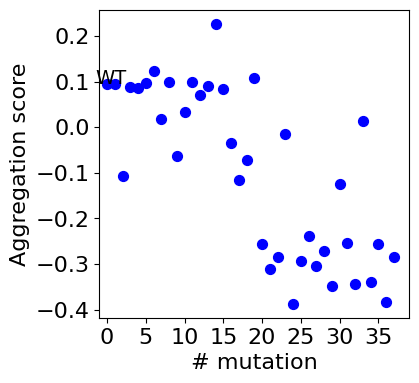

In [200]:
#task_A_0_indexes,df, LLM_score, y_predicted_ML_LM = ab42_taskA(logits_all)
df, y1 = ab42_taskB(logits_all, task_A_0_indexes)

,Mutation name,Classification task,Combined transition score,Combined Predicted label,Predicted label RF,Predicted label LLM
0,WT,A,1.141683,0,0,0
1,GM60,A,1.880281,0,0,0
2,GM76,A,1.478962,0,0,0
3,GM1,A,1.433176,0,0,0
4,GM74,A,1.757571,0,0,0
5,GM29,A,1.445165,0,0,0
6,GM34,A,1.281615,0,0,0
7,GM23,A,1.768865,0,0,0
8,GM72,A,1.781662,0,0,0
9,GM22,A,1.751933,0,0,0


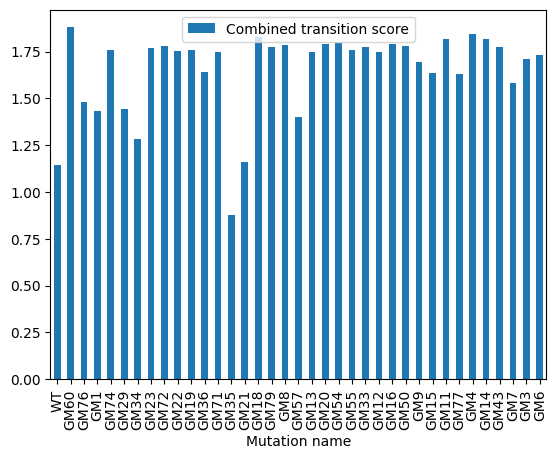

In [90]:
## For classification task A

mut_name = ab42_mut_table.columns.tolist()[1:]
task = ['A' for i in range(0, len(mut_name))]
score = LLM_score 
pred_label = y_predicted_ML_LM

d_mut = {'Mutation name': mut_name, 'Classification task':task,
        'Combined transition score': score, 'Combined Predicted label':pred_label,
       'Predicted label RF': ab42_RF_mut_label_B, 
         'Predicted label LLM': predicted_class_id_all}

df_mut = pd.DataFrame(data=d_mut)

df_mut.plot(x='Mutation name', y='Combined transition score', kind='bar')
df_mut.head(40)

In [20]:
## For classification task B

mut_name = ab42_mut_table.columns.tolist()[1:]
task = ['B' for i in range(0, len(mut_name))]
score = LLM_score 
pred_label = y_predicted_ML_LM

d_mut = {'Mutation name': mut_name, 'Classification task':task,
        'Combined transition score': score, 'Combined Predicted label':pred_label,
       'Predicted label RF': ab42_RF_mut_label_B, 
         'Predicted label LLM': predicted_class_id_all}

df_mut = pd.DataFrame(data=d_mut)

df_mut.head(40)

,Mutation name,Classification task,Combined transition score,Combined Predicted label,Predicted label RF,Predicted label LLM,flor
0,WT,B,0.095439,0,0,1,5.0
1,GM60,B,-0.107844,0,0,1,13.8
2,GM76,B,0.087947,0,0,1,15.3
3,GM1,B,0.085342,0,0,1,16.4
4,GM74,B,0.097257,0,0,1,20.0
5,GM29,B,0.123082,0,0,1,22.3
6,GM34,B,0.017874,0,0,1,22.8
7,GM23,B,0.099100,0,0,1,22.9
8,GM72,B,-0.063771,0,0,1,23.1
9,GM22,B,0.033515,0,0,1,23.5


In [172]:
df_mut['Combined transition score']< df_mut['Combined transition score'][0]

0     False
1      True
2      True
3      True
4     False
5     False
6      True
7     False
8      True
9      True
10    False
11     True
12     True
13    False
14     True
15     True
16     True
17     True
18    False
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
Name: Combined transition score, dtype: bool

### Calculate aggregation score from classification task B versus florescence intensity

(doi:10.1016/S0022-2836(02)00399-6, Fig.2)

In [ ]:
## plot aggregation score versus florescence intensity


dfs = {'Combined transition score': score, 'flor':flor}
df_s = pd.DataFrame(data=dfs)

corr_coef, p_value  = scipy.stats.pearsonr(df_mut['Combined transition score'],df_mut['flor'])
print('Pearson r', corr_coef, 'p-value', p_value)

plt.figure(figsize=(2.5,2.5))
ax=sns.regplot(data = df_s,  x="Combined transition score", y="flor",
              marker="o", color="b", line_kws=dict(color="r"), dropna = True)
plt.xlabel('Aggregation score', fontsize=15)
plt.ylabel('Florescence', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Extract self-attention maps

In [49]:
#### Save attention map for each classification task ####

## save attention for classification task A
#predicted_attentionA = results['attentions'][5][0]

## save attention for classification task B
#predicted_attentionB = results['attentions'][5][0]

In [50]:
def self_attention(predicted_results, seq_len):
    
    "input: predicted_results: model output (predictions),seq_len: sequence length"
    "Output: mean self attention map of all the 20 attention heads"
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax=ax.matshow((predicted_results.mean(0)[:seq_len,:seq_len])   ##plt
                , vmin=0, vmax=0.1 ,cmap=plt.cm.Spectral_r)
    
    # Set xticks and yticks
  
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    
    #plt.xlim(0,50)
    #plt.ylim(50,0)
    
    startp=240
    endp=248     # true lenght of the sequence
    plt.xlim(startp+1,endp-1)
    plt.ylim(endp-1,startp+1)
    
    
    plt.box(False)
    plt.tick_params(bottom = False)
    #cbar=plt.colorbar(shrink=0.8)
    cbar=fig.colorbar(cax,shrink=0.8)
    cbar.set_label(label='Attention score', fontsize=17)
    cbar.ax.tick_params(labelsize=17)
    
    ax.set(xticks=[i for i in range (startp,endp+1,2)], xticklabels= [i for i in range (startp+1,endp+2,2)],
           yticks=[i for i in range (startp,endp+1,2)], yticklabels= [i for i in range (startp+1,endp+2,2)])
    
    # for plotting 0-50
    #ax.set(xticks=[i for i in range (startp,endp,20)], xticklabels= [i for i in range (startp,endp,20)],
           #yticks=[i for i in range (startp,endp,20)], yticklabels= [i for i in range (startp,endp,20)])
  
        
    print((predicted_results.mean(0)[:seq_len,:seq_len])[startp:endp,startp:endp])
    my_mat = (predicted_results.mean(0)[:seq_len,:seq_len])[startp:endp,startp:endp]
    print(my_mat.shape)
   
    
    var_type = 'FUS_R244C_short_9'
    task = 'B'
    
    return(my_mat)

tensor([[0.0717, 0.0333, 0.0315, 0.0248, 0.0164, 0.0111, 0.0046, 0.0039],
        [0.0951, 0.0346, 0.0302, 0.0286, 0.0222, 0.0121, 0.0066, 0.0051],
        [0.0548, 0.0683, 0.0520, 0.0289, 0.0254, 0.0143, 0.0111, 0.0060],
        [0.0500, 0.0392, 0.0881, 0.0398, 0.0330, 0.0218, 0.0167, 0.0118],
        [0.0241, 0.0244, 0.0414, 0.0730, 0.0412, 0.0240, 0.0236, 0.0168],
        [0.0179, 0.0186, 0.0297, 0.0394, 0.0903, 0.0283, 0.0274, 0.0186],
        [0.0127, 0.0121, 0.0191, 0.0264, 0.0533, 0.0711, 0.0359, 0.0213],
        [0.0154, 0.0131, 0.0161, 0.0170, 0.0394, 0.0389, 0.0750, 0.0280]])
torch.Size([9, 9])


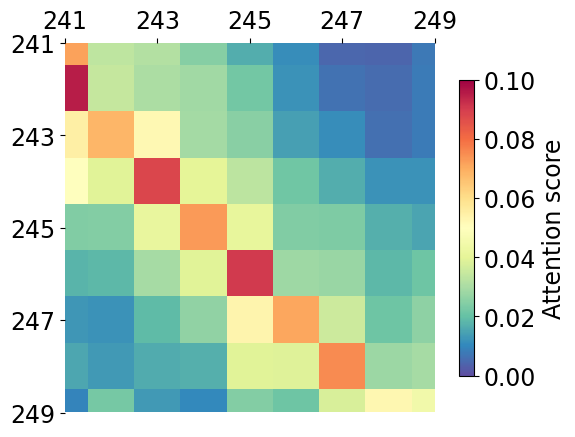

In [68]:
### calculate self attention map
my_matA = self_attention(results['attentions'][5][0],  b_input_ids.shape[1])

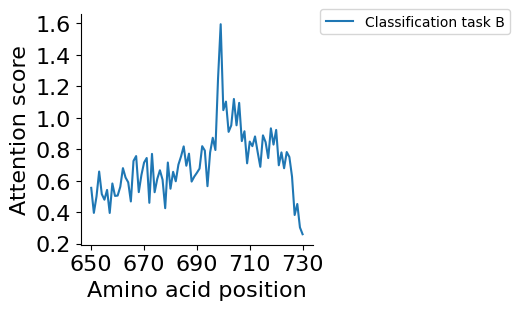

In [69]:
### Calculate line plot for self-attention map

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
#plt.plot(my_matA.sum(0))
plt.plot(my_matB.sum(0))
plt.legend(['Classification task B'], bbox_to_anchor=(1, 1.05))
startp=649
endp = 730
plt.xlabel('Amino acid position', fontsize=16)
plt.ylabel('Attention score', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xticks=[i for i in range (0,81,20)], xticklabels= [i for i in range (startp+1,endp+2,20)])

### Getting Vector embedding

In [52]:
### to load pickle files that were dumped with GPU using CPU
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [53]:
### load labels for +Droplet drivers & +Amyloids vesus -PT test set 
            
with open('final_files/das_test_labels_val', 'rb') as fp:
                         das_test_labels_val = CPU_Unpickler(fp).load()
                       # das_test_labels_val = pickle.load(fp)

In [55]:
## load labels for +Droplet drivers versus +Amyloids test set
      
with open('final_files/droplets_amyloids_test_labels_val', 'rb') as fp:
                         droplets_amyloids_test_labels_val = CPU_Unpickler(fp).load()
                        #droplets_amyloids_test_labels_val = pickle.load(fp)

In [59]:
## load labels for +Droplet drivers and +Amyloids vesus -PT train set    
        
with open('final_files/das_train_labels', 'rb') as fp:
                         das_train_labels = CPU_Unpickler(fp).load()

In [ ]:
## load labels for +Droplet drivers versus +Amyloids train set 
with open('final_files/droplets_amyloids_train_labels', 'rb') as fp:
                         droplets_amyloids_train_labels = CPU_Unpickler(fp).load()

In [5]:
def get_embedding_vectors(input_ids, attention_masks, data_indexes):
    "input: input_ids: tokens for the input sequences, attention_masks: attention masks for the input sequences"
    "data_indexes: indexes in train/test sets. For a new sequence, the user can choose indexes."

    # Gradients are not computed 
    with torch.no_grad():        

    #load saved model and use it to make predictions
        predictions = saved_model(input_ids[data_indexes], attention_mask=attention_masks[data_indexes],output_hidden_states = True, output_attentions=True)
        hidden_states = predictions.hidden_states[6]
    torch.cuda.empty_cache()
    
    return(hidden_states)

In [ ]:
## Compute embedding vectors for for the train and test sets.
# Can be used also to compute embedding for any protein sequence

embed_train = get_embedding_vectors(input_ids, attention_masks, train_dataset_idx)
embed_test =  get_embedding_vectors(input_ids, attention_masks, val_dataset_idx)

In [6]:
def avg_embedded_vectors(sequence_lables, sequence_embedding_vectors):
    "input: sequence labels, all sequences embedding vectors represent each amino acids in the sequences"
    "output: average embedding vector for each sequence computed from the 6 layer (last layer)"
    "avg__embedding_0 - embedding vectors of class 0, avg__embedding_0 - embedding vectors of class 1"
    
    avg_embedding_0 = []
    avg_embedding_1 = []
    avg_embedding_2 = [] #added
    
    for num,i in enumerate(sequence_embedding_vectors):
    
        if sequence_lables.tolist()[num]==0:
            avg_embedding_0.append(i.mean(0).tolist())
        
        ## add embedding_2  (T0 distinguish between +Droplet drivers and +Amyloids in Fig.3A)
        if sequence_lables.tolist()[num]==2:
            avg_embedding_2.append(i.mean(0).tolist()) 
        
        if sequence_lables.tolist()[num]==1:
            avg_embedding_1.append(i.mean(0).tolist())

    return(avg_embedding_0, avg_embedding_1, avg_embedding_2)

### PCA analysis

In [7]:
def PCA_analysis(avg_embedding_0, avg_embedding_1, avg_embedding_2, label0, label1, task):

    #X = np.array(da_0+da_1)
    #Y = [0]*len(da_0)+[1]*len(da_1)

    X = np.array(avg_embedding_0 + avg_embedding_1 + avg_embedding_2)
    Y = [0]*len(avg_embedding_0)+[1]*len(avg_embedding_1)+[2]*len(avg_embedding_2)


    pca = PCA(n_components=2)
    Xt = pca.fit_transform(X)


    #orig_map=plt.cm.get_cmap('bwr')
    # reversing the original colormap using reversed() function
    #reversed_map = orig_map.reversed()

    
    #fig, (ax1) = plt.subplots(1, figsize=(8,6))
    fig, (ax1) = plt.subplots(1, figsize=(5,4))
    
    if avg_embedding_2==[] and task=='A':
        colormap = np.array(['violet', 'g'])
    if avg_embedding_2==[] and task=='B':
        colormap = np.array(['red', 'blue'])
    else:
        colormap = np.array(['firebrick', 'violet', 'g'])
    #plt.setp(ax1.spines.values(), color='black')
    
    
    amyloid = mpatches.Patch(color = "firebrick", label = "+Amyloids")
    amyloid_b = mpatches.Patch(color = "red", label = "+Amyloids")
    
    droplet_drivers = mpatches.Patch(color = "violet", label = "+Droplet drivers")
    droplet_drivers_b = mpatches.Patch(color = "blue", label = "+Droplet drivers")
    
    amyloid_droplet_drivers = mpatches.Patch(color = "violet", label = label0)
    
    PT = mpatches.Patch(color = "g", label = "-PT")
    

    #plot = ax1.scatter(Xt[:,0], Xt[:,1], c=Y, cmap = reversed_map, alpha=0.5)
    
    plot = ax1.scatter(Xt[:,0], Xt[:,1], c=colormap[np.array(Y)], alpha=0.5)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
   
    plt.xlabel(f'PC1 {[np.round(pca.explained_variance_ratio_[0], decimals=2)]}', fontsize='16')
    plt.ylabel(f'PC2 {[np.round(pca.explained_variance_ratio_[1], decimals=2)]}', fontsize = '16')
    plt.xticks(fontsize='14')
    plt.yticks(fontsize='14')
    
     #plt.legend(handles=plot.legend_elements()[0], labels=[f'{label0}', f'{label1}'], fontsize='14')
    #plt.legend(
               #labels=['+Amyloids', '+Droplet drivers','-PT'], loc='upper right', bbox_to_anchor=(1.47, 1.02))
    #ax1.legend(labels=['+Amyloids', '+Droplet drivers','-PT'])
    
    
    if avg_embedding_2==[]:
        if task == 'A':
            plt.legend(handles = [amyloid_droplet_drivers, PT],
                   loc='upper right', bbox_to_anchor=(1.47, 1.02), fontsize=13)
        else:
            plt.legend(handles = [amyloid_b, droplet_drivers_b],
               loc='upper right', bbox_to_anchor=(1.47, 1.02), fontsize=13)
    else:
        plt.legend(handles = [amyloid,  droplet_drivers, PT],
                   loc='upper right', bbox_to_anchor=(1.47, 1.02), fontsize=13)
    
    
    return()

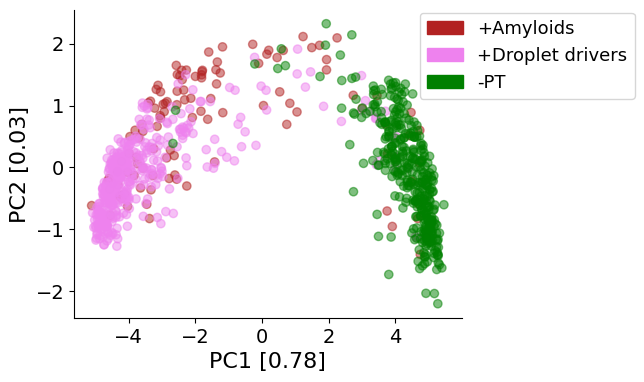

()

In [121]:
### embedded vectors and labels for the +Droplet drivers & +Amyloids versus -PT
## +Amyloids and +Droplet drivers can be distinguished

all_embed_das =  embed_train + embed_test
#all_labels_das = torch.cat((das_train_labels, das_test_labels_val), 0)
all_labels_das = torch.cat((torch.tensor(np.array(ycolor)[train_dataset_idx])
                            , torch.tensor(np.array(ycolor)[val_dataset_idx])), 0)


label0 = '+Amyloids&\n+Droplet drivers'
label1 = '-PT'
avg_embedding_0, avg_embedding_1, avg_embedding_2 = avg_embedded_vectors(all_labels_das,all_embed_das)

PCA_analysis(avg_embedding_0, avg_embedding_1,avg_embedding_2, label0, label1, task='A')

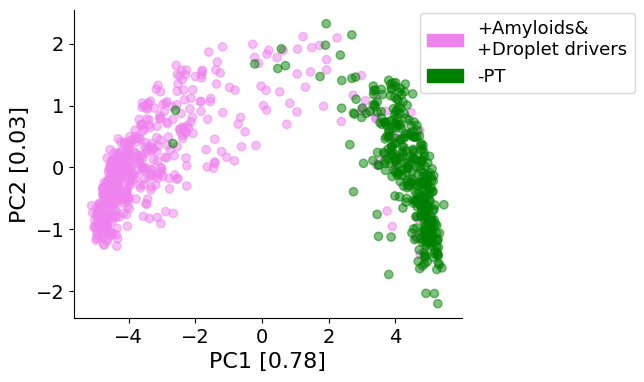

()

In [65]:
### embedded vectors and labels for the +Droplet drivers & +Amyloids versus -PT

all_embed_das =  embed_train + embed_test
all_labels_das = torch.cat((das_train_labels, das_test_labels_val), 0)

label0 = '+Amyloids&\n+Droplet drivers'
label1 = '-PT'
avg_embedding_0, avg_embedding_1, avg_embedding_2 = avg_embedded_vectors(all_labels_das,all_embed_das)

PCA_analysis(avg_embedding_0, avg_embedding_1,avg_embedding_2, label0, label1)

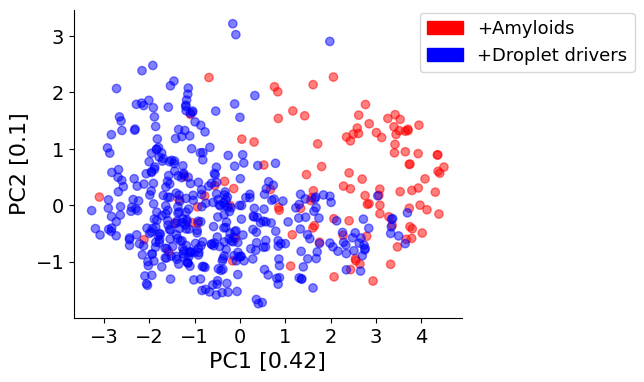

()

In [80]:
### embedded vectors and labels for the +Droplet drivers versus +Amyloids

all_embed_das =  da_embed_train + droplets_amyloids_embed_test
all_labels_das = torch.cat(( droplets_amyloids_train_labels, droplets_amyloids_test_labels_val), 0)

label0 = '+Amyloids'
label1 = '+Droplet drivers'
avg_embedding_0, avg_embedding_1, avg_embedding_2 = avg_embedded_vectors(all_labels_das,all_embed_das)

PCA_analysis(avg_embedding_0, avg_embedding_1,avg_embedding_2, label0, label1, task='B')